# **Import libraries**

In [96]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout
import matplotlib.pyplot as plt

# **Load data**

In [97]:
rets = pd.read_csv('all_rets.csv', index_col=0)
data = rets.values
data.shape

(521, 54)

In [98]:
# Prepare the data for training
def create_dataset(data, time_window=1):
    X, Y = [], []

    for i in range(len(data)-time_window):
        X.append(data[i:(i+time_window)])
        Y.append(data[i + time_window])
    return np.array(X), np.array(Y)

# Generate the sequences of data
time_window = 54
X, Y = create_dataset(data, time_window)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (467, 54, 54)
Shape of Y: (467, 54)


In [99]:
# Define Train and Test sets
X_train = X[:-8]
y_train = Y[:-8]
X_test = X[-8:]
y_test = Y[-8:]

# **Define the Transformer Neural Network**

### **Implement Positional Encoding**

In [100]:
# Positional encoding represents the data in time steps
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super().__init__()
        self.sequence_length = sequence_length
        self.d_model = d_model

    def call(self, inputs):
        positions = np.arange(self.sequence_length)[:, np.newaxis]
        # div_term = np.exp(np.arange(0, self.d_model, 2) * (-np.log(10000.0) / self.d_model))
        div_term = 2 * np.arange(1, self.d_model + 1, 2) / self.d_model
        pos_encoding = np.zeros((self.sequence_length, self.d_model))
        pos_encoding[:, 0::2] = np.sin(positions * div_term)
        pos_encoding[:, 1::2] = np.cos(positions * div_term)
        return inputs + tf.convert_to_tensor(pos_encoding, dtype=tf.float32)

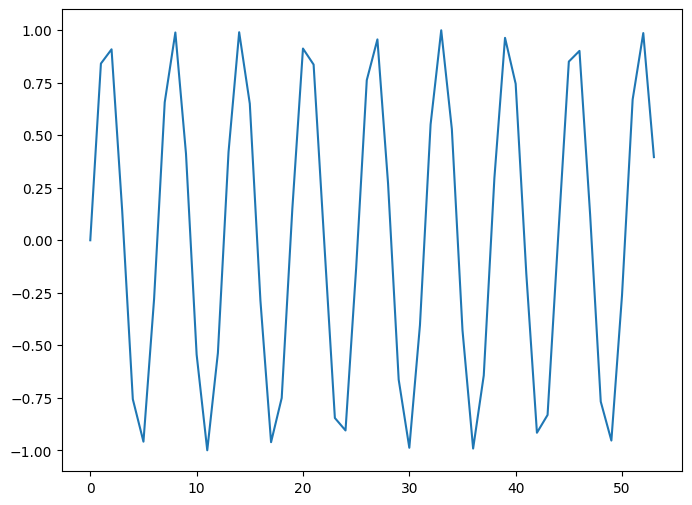

In [118]:
# Just to examine what the positional encoding is doing
positions = np.arange(time_window)[:, np.newaxis]
#div_term = np.exp(np.arange(0, X.shape[2], 2) * (-np.log(10000.0) / X.shape[2]))
div_term = 1 / (100 ** (2 * np.arange(0, X.shape[2], 2) / X.shape[2]))
#div_term = np.exp(100 * 2 * np.arange(0, X.shape[2], 2) / X.shape[2])
pos_encoding = np.zeros((time_window, X.shape[2]))
pos_encoding[:, 0::2] = np.sin(positions * div_term)
pos_encoding[:, 1::2] = np.cos(positions * div_term)



plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(positions)), pos_encoding[:, 0])
plt.show()
#pos_encoding
#div_term

### **Implement Transformer Encoder Block**

In [102]:
# Implement Multi-Head Self-Attention, Layer Normalization, and Feed-Forward Networks
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Self-Attention
    x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed-Forward Network
    ff_output = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
    ff_output = tf.keras.layers.Dense(inputs.shape[-1])(ff_output)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    return x

### **Build the transformer model**

In [103]:
# Function that builds the model that will take inputs, encode them, and then make a prediction for the input_shape[1] items
def build_transformer_model(input_shape, head_size=64, num_heads=4, ff_dim=128, num_transformer_blocks=2, dropout=0.1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Positional Encoding
    x = PositionalEncoding(sequence_length=input_shape[0], d_model=input_shape[1])(inputs)
    
    # Transformer Encoder Blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    # Global Average Pooling over time dimension
    x = tf.keras.layers.GlobalAveragePooling1D()(x)

    # Output Layer (input_shape[1]-dimensional vector)
    outputs = tf.keras.layers.Dense(input_shape[1])(x)

    # Build Model
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="mse",
        metrics=["mae", tf.keras.metrics.RootMeanSquaredError]
    )
    
    return model

# **Train the model**

In [104]:
input_shape = (time_window, X.shape[2])
head_size = 128
num_heads = 6
ff_dim = 512
num_transformer_blocks = 6
dropout = 0.2

model = build_transformer_model(input_shape)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 54, 54)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 54, 54)    │          0 │ input_layer_2[0]… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 54, 54)    │     56,118 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 54, 54)    │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 54, 54)    │        108 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 54, 128)   │      7,040 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 54, 54)    │      6,966 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 54, 54)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 54, 54)    │        108 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 54, 54)    │     56,118 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 54, 54)    │          0 │ multi_head_atten… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 54, 54)    │        108 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 54, 128)   │      7,040 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 54, 54)    │      6,966 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 54, 54)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 54, 54)    │        108 │ add_11[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 54)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 54)        │      2,970 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 143,650 (561.13 KB)

 Trainable params: 143,650 (561.13 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1072 - mae: 0.2674 - root_mean_squared_error: 0.3258 - val_loss: 0.0311 - val_mae: 0.1424 - val_root_mean_squared_error: 0.1763
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0241 - mae: 0.1225 - root_mean_squared_error: 0.1546 - val_loss: 0.0096 - val_mae: 0.0764 - val_root_mean_squared_error: 0.0979
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0086 - mae: 0.0687 - root_mean_squared_error: 0.0925 - val_loss: 0.0049 - val_mae: 0.0534 - val_root_mean_squared_error: 0.0699
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0054 - mae: 0.0503 - root_mean_squared_error: 0.0732 - val_loss: 0.0036 - val_mae: 0.0434 - val_root_mean_squared_error: 0.0602
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0032 - mae: 0.0406 - root_mean_squared_error: 0.0565 - val_loss: 0.0030 - val_mae: 0.0391 - val_root_mean_squared_error: 0.0548
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - lo

### **Model evaluation**

In [106]:
preds = []
pred_inputs = np.expand_dims(X_test[0], axis=0)
for i in range(len(y_test)):
    prediction = model.predict(pred_inputs)
    preds.append(prediction[0])
    pred_inputs = np.concatenate((pred_inputs[0][1:], np.expand_dims(prediction[0], axis=0)))
    pred_inputs = np.expand_dims(pred_inputs, axis=0)

preds = np.array(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [107]:
# Average RMSE across all stocks
n8_periods_rmse = np.mean(np.sqrt(np.mean((preds - y_test)**2, axis=0)))
n4_periods_rmse = np.mean(np.sqrt(np.mean((preds[:4] - y_test[:4])**2, axis=0)))
n1_periods_rmse = np.mean(np.sqrt((preds[0] - y_test[0])**2))

print(f'1 period RMSE: {n1_periods_rmse.round(6)}')
print(f'4 periods RMSE: {n4_periods_rmse.round(6)}')
print(f'8 periods RMSE: {n8_periods_rmse.round(6)}')

1 period RMSE: 0.029063
4 periods RMSE: 0.04578
8 periods RMSE: 0.041169


In [108]:
# Generate a dataframe for the predictions
preds_df = pd.DataFrame(preds, columns=rets.columns, index=rets.iloc[-len(preds):].index)

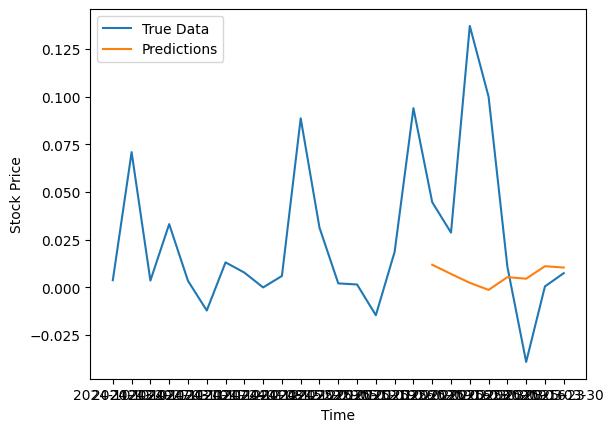

In [109]:
# Plot an example of a stock comparing the actual values against the predicted values
stock = 'PFGRUPSURA.CL'
plt.plot(rets[stock][-25:], label='True Data') 
plt.plot(preds_df[stock], label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.show() 